# Projeto Spark

Alunos:

- Davi Reis
- Guilherme Rameh
- Nicolas Queiroga

Entrega: 6 de dezembro de 2022

## Introdução

Neste projeto vamos construir um classificador Naive-Bayes para determinar o sentimento de um comentário.

## Instalando o ambiente

O jeito mais simples de começar a trabalhar com Spark é instalar um container com tudo pronto! No site https://hub.docker.com/r/jupyter/pyspark-notebook vemos uma imagem Docker que já vem com `pyspark` e `jupyter lab`. Instale a imagem com o comando:

```bash
docker pull jupyter/pyspark-notebook
```

Vamos iniciar o ambiente de trabalho com o comando `docker run`. Para isso precisamos tomar alguns cuidados:

1) Temos que mapear nosso diretorio local de trabalho para um diretório interno do container, de modo que alterações feitas dentro do container (nesta pasta escolhida) sejam gravadas no nosso diretorio local. No container temos um usuário padrão com *username* `jovyan`. No *homedir* desse usuario temos uma pasta vazia `work`, que vai servir como local de mapeamento do nosso diretorio local de trabalho. Podemos então fazer esse mapeamendo com a opção `-v` do comando `docker run` da seguinte forma:

```bash
-v <diretorio>:/home/jovyan/work
```

onde `<diretorio>` representa seu diretorio local de trabalho.

2) Para acessar o `jupyter notebook` e o *dashboard* do Spark a partir do nosso *browser* favorito temos que abrir algumas portas do container com a opção `-p`. As portas são `8888` (para o próprio `jupyter notebook`) e `4040` (para o *dashboard* do Spark). Ou seja, adicionaremos às opções do `docker run`o seguinte:

```bash
-p 8888:8888 -p 4040:4040
```

Desta forma, ao acessar `localhost:8888` na nossa máquina, estaremos acessando o servidor Jupyter na porta 8888 interna do container.

3) Vamos iniciar o container no modo interativo, e vamos especificar que o container deve ser encerrado ao fechar o servidor Jupyter. Faremos isso com as opções `-it` e `-rm`

Portanto, o comando completo que eu uso na minha máquina Linux para iniciar o container é:

```bash
docker run \
    -it \
    --rm \
    -p 8888:8888 \
    -p 4040:4040 \
    -v `pwd`:/home/jovyan/work \
    jupyter/pyspark-notebook


```

Para facilitar a vida eu coloco esse comando em um arquivo `inicia.sh`. Engenheiros, façam do jeito que preferirem!

Agora abra esse notebook lá no container!


## Iniciando o Spark

Vamos iniciar o ambiente Spark. Para isso vamos:

1) Criar um objeto de configuração do ambiente Spark. Nossa configuração será simples: vamos especificar que o nome da nossa aplicação Spark é "Minha aplicação", e que o *master node* é a máquina local, usando todos os *cores* disponíveis. Aplicações reais de Spark são configuradas de modo ligeiramente diferente: ao especificar o *master node* passamos uma URL real, com o endereço do nó gerente do *cluster* Spark.

2) Vamos criar um objeto do tipo `SparkContext` com essa configuração

In [1]:
import pyspark

conf = pyspark.SparkConf()
conf.setAppName('Projeto Spark')
conf.setMaster('local[*]')

sc = pyspark.SparkContext(conf=conf)

O `SparkContext` é a nossa porta de entrada para o cluster Spark, ele será a raiz de todas as nossas operações com o Spark.

In [2]:
sc

<SparkContext master=local[*] appName=Projeto Spark>

O link acima provavelmente não funcionará porque ele se refere à porta 4040 interna do container (portanto a URL está com endereço interno). Porém fizemos o mapeamento da porta 4040 interna para a porta 4040 externa, logo você pode acessar o *dashboard* do Spark no endereço http://localhost:4040

<center><img src="./spark_dashboard.png" width=800/></center>

## Lendo os dados

Vamos começar lendo o arquivo de reviews e gravando o resultado em formato pickle, mais amigável.

In [3]:
def parse_line(line):
    parts = line[1:-1].split('","')
    sentiment = int(parts[0])
    title = parts[1].replace('""', '"')
    body = parts[2].replace('""', '"')
    return (sentiment, title, body)

rdd = sc.textFile('train.csv').map(parse_line)

In [4]:
rdd.count()

3600000

In [5]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora vamos gravar no formato pickle, para facilitar os trabalhos futuros. Após gravar o arquivo, não mais rode as células desta primeira etapa!

In [6]:
rdd.saveAsPickleFile('reviews.pickle')

## Um classificador Naive-Bayes

Vamos ler o arquivo pickle gravado anteriormente:

In [3]:
rdd = sc.pickleFile('reviews.pickle')

In [4]:
rdd.count()

3600000

In [5]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora, complete as tarefas em sequencia para construir o classificador Naive-Bayes:

### Fase 1

In [6]:
import numpy as np

#### Tarefa

Construa uma função que recebe um RDD no formato do RDD original e retorna um RDD no qual cada item é um par (palavra, contagem).

In [7]:
def word_count(rdd):
    return rdd.flatMap(lambda x: x[1].split() + x[2].split()).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)

#### Tarefa

Construa uma função que recebe o RDD (palavra, contagem) construido anteriormente e retorna um RDD no qual cada item é um par (palavra, $\log_{10}\left(c \, / \, T\right)$), onde $c$ é a contagem daquela palavra e $T$ é a soma das contagens de palavra.

In [8]:
def word_log_count(rdd):
    total_count = rdd.map(lambda x: x[1]).reduce(lambda x, y: x + y)
    return rdd.map(lambda x: (x[0], np.log10(x[1] / total_count)))

#### Tarefa

Separe o RDD original em dois RDDs: o dos reviews positivos e o dos negativos. Em seguida, use as funções anteriores para construir RDDs que contem os pares (palavra, $\log_{10}\left(c \, / \, T\right)$)

In [9]:
def split_by_sentiment(rdd):
    positive = rdd.filter(lambda x: x[0] == 1)
    negative = rdd.filter(lambda x: x[0] == 2)
    return positive, negative

In [10]:
rdd_positive, rdd_negative = split_by_sentiment(rdd)

In [11]:
rdd_positive_log_count = word_log_count(word_count(rdd_positive))
rdd_negative_log_count = word_log_count(word_count(rdd_negative))

### Tarefa

Use o `.fullOuterJoin()` dos RDDs para construir um RDD unificado, no qual cada item é da forma (palavra, log_prob_positivo, log_prob_negativo). "Baixe" esse resultado final usando `.collect()`.

In [12]:
rdd_unified = rdd_positive_log_count.fullOuterJoin(rdd_negative_log_count).map(lambda x: (x[0], x[1][0], x[1][1]))

rdd_unified.take(10)

[('family', -3.9203467150039017, -3.4798931704033724),
 ('purposes.', -5.277100209404035, -5.203975964453867),
 ('out', -2.596022446951644, -2.6616432990632193),
 ('timbre', -6.374010222412092, -6.046523824023071),
 ('24', -4.498109201462125, -4.609137187886255),
 ('kinda', -4.418990104023922, -4.380912079961492),
 ("Allman's", -7.321303871896089, -6.85413005374499),
 ('flour', -5.291920094210879, -5.323997787338007),
 ('function,', -5.352820923342153, -5.521160346690477),
 ('returns', -4.723138924451651, -4.881245434249607)]

- Testando para a palavra 'Slow'

In [13]:
rdd_positive_log_count.filter(lambda x: x[0] == 'Slow').collect()

[('Slow', -4.7481006205906)]

In [14]:
rdd_negative_log_count.filter(lambda x: x[0] == 'Slow').collect()

[('Slow', -5.092281314583746)]

#### Tarefa

Para uma dada string, determine se ela é um review positivo ou negativo usando os RDDs acima. Lembre-se de como funciona o classificador Naive-Bayes: http://stanford.edu/~jurafsky/slp3/slides/7_NB.pdf, consulte tambem suas notas de aula de Ciência dos Dados!

Na célula abaixo fazemos uma classe que contem todas as funções que usamos anteriormente para calcular o log das palavras, e uma função chamada 'classify', que acumula o valor dos logs positivo e negativo de cada palavra dado uma frase passada.

In [15]:
class NaiveBayes:
    def __init__(self, rdd):
        self.rdd = rdd
        self.positive, self.negative = self.split_by_sentiment(rdd)
        self.positive_count = self.positive.count()
        self.negative_count = self.negative.count()
        self.total_count = self.positive_count + self.negative_count
        self.positive_log_count = self.word_log_count(self.word_count(self.positive))
        self.negative_log_count = self.word_log_count(self.word_count(self.negative))
        self.unified = self.positive_log_count.fullOuterJoin(self.negative_log_count).map(lambda x: (x[0], x[1][0], x[1][1]))

    def split_by_sentiment(self, rdd):
        positive = rdd.filter(lambda x: x[0] == 1)
        negative = rdd.filter(lambda x: x[0] == 2)
        return positive, negative

    def word_log_count(self, rdd):
        total_count = rdd.map(lambda x: x[1]).reduce(lambda x, y: x + y)
        return rdd.map(lambda x: (x[0], np.log10(x[1] / total_count)))

    def word_count(self, rdd):
        return rdd.flatMap(lambda x: x[1].split()).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)

    def classify(self, text):
        positive = 0
        negative = 0
        for word in text.split():
            positive += self.unified.filter(lambda x: x[0] == word).map(lambda x: x[1]).collect()[0]
            negative += self.unified.filter(lambda x: x[0] == word).map(lambda x: x[2]).collect()[0]
        if positive < negative:
            return 2, positive
        else:
            return 1, negative

In [16]:
nb = NaiveBayes(rdd)

- Testando o classificador

In [17]:
test = "The best game for my kids. I love"
classification, score = nb.classify(test)
print('Classification: {}, Score: {}'.format(classification, score))

Classification: 2, Score: -23.150172896477194


### Fase 2

Agora que temos um classificador Naive-Bayes, vamos explorá-lo um pouco:

### Tarefa

Quais são as 100 palavras que mais indicam negatividade, ou seja, onde a diferença entre a probabilidade da palavra no conjunto dos comentários negativos e positivos é máxima? E quais as 100 palavras de maior positividade? Mostre os resultados na forma de *word clouds*.

In [18]:
rdd_unified_fase_2 = rdd_positive_log_count.fullOuterJoin(rdd_negative_log_count)

In [19]:
positivity_words = rdd_unified_fase_2.filter(lambda x: x[1][0] != None).filter(lambda x: x[1][1] != None).map(lambda x:(x[0], (x[1][1]) - (x[1][0]))).takeOrdered(100, lambda x: -x[1])
positivity_words

[('Excellent!!!', 2.4226843415770585),
 ('must-read!', 2.2430332717551567),
 ('Inspiring!', 2.226642855566988),
 ('Outstanding!', 2.220333381659981),
 ('Excellent!!', 2.1827373698679065),
 ('Adorable!', 2.173397343613763),
 ('Underrated', 2.1491287688868264),
 ('Bookwatch', 2.1407282268603938),
 ('Fantastic!!', 2.137321978168483),
 ('Excellent!', 2.0897600634096705),
 ('Gem!', 2.086596700695946),
 ('must-have!', 2.080793124596706),
 ('Insightful!', 2.0749109423707512),
 ('Awesome!!!', 1.987760766651851),
 ('Excelente', 1.9845317965216527),
 ('MUST!', 1.9829082638574391),
 ('FANTASTIC!!!', 1.9780009293626941),
 ('Pleasantly', 1.973750052209037),
 ('Beautiful!', 1.9658470395875813),
 ('Superb!', 1.95650307292141),
 ('Captivating!', 1.9473321095962426),
 ('Mesmerizing', 1.9366082442044705),
 ('Impressive!', 1.9311453485029677),
 ('Eye-opening', 1.9256128599030067),
 ('Inspirational!', 1.9256128599030067),
 ('Underappreciated', 1.908579520604226),
 ('Addictive!', 1.9027499769435021),
 ('Mu

In [20]:
negativity_words = rdd_unified_fase_2.filter(lambda x: x[1][0] != None).filter(lambda x: x[1][1] != None).map(lambda x:(x[0], (x[1][0]) - (x[1][1]))).takeOrdered(100, lambda x: -x[1])
negativity_words

[('Worthless', 2.7038334385911877),
 ('Awful!', 2.63719133801127),
 ('Terrible!', 2.5171176927583643),
 ('Uninspired', 2.5055578415802504),
 ('Avoid!', 2.4941116436588127),
 ('Useless.', 2.491526549824319),
 ('Disappointed...', 2.491526549824319),
 ('JUNK!!!', 2.455032459287918),
 ('Junk!', 2.442636824735115),
 ('worthless!', 2.430374731773381),
 ('Worthless.', 2.4105265387055494),
 ('unfunny,', 2.404232305607861),
 ('Dull,', 2.390546268204961),
 ('Unreliable', 2.3502971087679043),
 ('JUNK!', 2.3466929844990796),
 ('Horrible.', 2.3181814431927394),
 ('Disappointing...', 2.3079162673656137),
 ('Horrible!', 2.3065952184933094),
 ('Tripe', 2.2782356038432283),
 ('Disappointment!', 2.259844297498919),
 ('Yawn', 2.2467565168608354),
 ('Boring,', 2.24440336171976),
 ('GARBAGE!', 2.2277446115799666),
 ('Atrocious', 2.2119944106016236),
 ('Unsatisfactory', 2.202010189695023),
 ('Disappointing.', 2.2011677171090014),
 ('Misrepresentation', 2.194368447401147),
 ('USELESS.', 2.186589830827529),
 

In [21]:
!pip install wordcloud

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(words):
    wordcloud = WordCloud().generate_from_frequencies(dict(words))
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

- Palavras Positivas

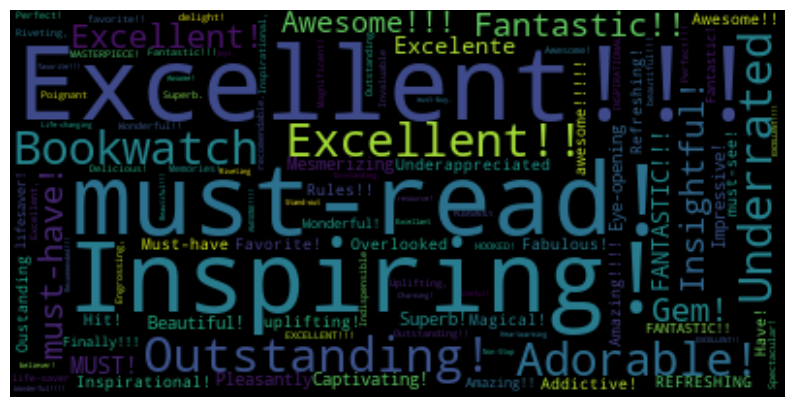

In [23]:
plot_wordcloud(positivity_words)

- Palavras Negativas

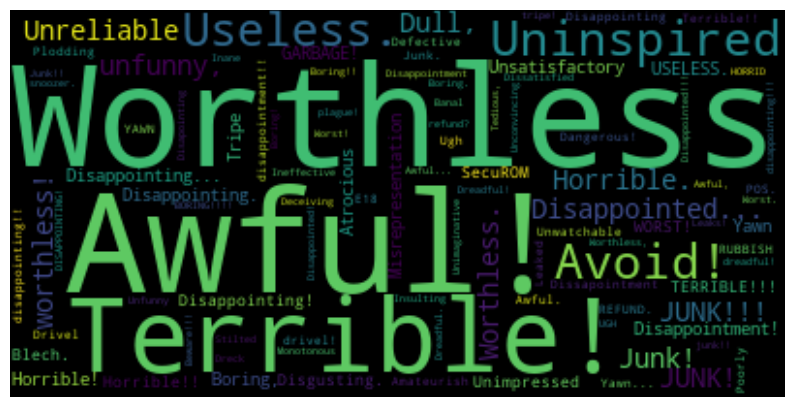

In [24]:
plot_wordcloud(negativity_words)

### Tarefa desafio!

Qual o desempenho do classificador (acurácia)? Para medir sua acurácia:

- Separe os reviews em dois conjuntos: treinamente e teste
- Repita o "treinamento" do classificador com o conjunto de treinamento
- Para cada review do conjunto de teste, determine se é positiva ou negativa de acordo com o classificador
- Determine a acurácia

Esta não é uma tarefa trivial. Não basta fazer um `for` para determinar a classe de cada review de teste: isso demoraria uma eternidade. Você tem que usar variáveis "broadcast" do Spark para enviar uma cópia da tabela de frequencias para cada *core* do executor.

- Dividindo os dados

In [25]:
train, test = rdd.randomSplit([0.8, 0.2], seed=42)

In [26]:
train.count()

2879660

In [27]:
test.count()

720340

In [28]:
nb_train = NaiveBayes(train)

In [29]:
def classify_new(text, training_set):
    training = training_set.value
    
    positive = 0
    negative = 0
    for word in text.split():
        if word in training and training[word][0] != None and training[word][1] != None:
            positive += training[word][0]
            negative += training[word][1]
    if positive <negative:
        return 2, positive
    else:
        return 1, negative

In [30]:
from functools import partial

all_words = nb_train.unified.collect()

all_words_dict = {}
for word in all_words:
    all_words_dict[word[0]] = word[1:]

training_set = sc.broadcast(all_words_dict)

In [31]:
classify_new_final = partial(classify_new, training_set=training_set)

In [32]:
print(classify_new_final('The best game for my kids. I love'))

(2, -23.128636539155004)


In [33]:
test_classified = test.map(lambda x: (x[0], x[1], classify_new_final(x[1])))
test_classified.take(5)

[(2, 'Whispers of the Wicked Saints', (2, -19.895657807386137)),
 (2, 'Great book', (2, -4.956457850138497)),
 (1, "Don't try to fool us with fake reviews.", (1, -30.688465792206763)),
 (1,
  'sizes recomended in the size chart are not real',
  (1, -31.59941270638676)),
 (2, 'Delicious cookie mix', (2, -14.606857079894539))]

- Analisando a acurácia do classificador

In [34]:
correct = test_classified.filter(lambda x: x[0] == x[2][0]).count()
total = test_classified.count()
print(total)
accuracy = correct / total
print('Accuracy: {:.3f}%'.format(accuracy*100))

720340
Accuracy: 82.202%


### Tarefa desafio!

Implemente Laplace smoothing

In [41]:
def laplace_smoothing(rdd, T, v=171476, alpha=1):
    op = rdd.map(lambda x: (x[0], np.log10((x[1] + alpha) / (T[1] + alpha * v))))
    return op

In [42]:
count = word_count(rdd)
T = count.reduce(lambda x, y: ("all", x[1] + y[1]))

smothing = laplace_smoothing(rdd=rdd, T=T).take(10)


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 115.0 failed 1 times, most recent failure: Lost task 0.0 in stage 115.0 (TID 3605) (19d9bed73736 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 686, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 678, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 273, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rdd.py", line 1877, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_14250/4148573248.py", line 2, in <lambda>
TypeError: can only concatenate str (not "int") to str

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:765)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:747)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:166)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2268)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 686, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 678, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 273, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rdd.py", line 1877, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_14250/4148573248.py", line 2, in <lambda>
TypeError: can only concatenate str (not "int") to str

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:765)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:747)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:166)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2268)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


In [38]:
T

('all', 282485435)

In [39]:
smothing

PythonRDD[99] at RDD at PythonRDD.scala:53

## Rubrica de avaliação

- I: groselha, falha crítica, ou não entregou nada
- D: Fez uma tentativa honesta de fazer todos os itens da fase 1, mas tem erros
- C: Fase 1 completa OK
- B: Fase 2, faltando apenas um desafio OK
- A: Fase 2 completa